In [1]:
import os
os.chdir('/home/xinglong/git_local/ssm-jax')
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from jax import jit
import collections
import blackjax
import jax.numpy as jnp
import jax.random as jr
import numpy as np 
import tensorflow_probability as tfp
tfd = tfp.distributions
from ssm_jax.utils import PSDToRealBijector
from jax import lax
import ssm_jax.structural_time_series.models.sts as sts
from ssm_jax.structural_time_series.models.sts_ssm import StructuralTimeSeriesSSM
from abc import ABC
from abc import abstractmethod
from collections import OrderedDict
import jax.numpy as jnp
import jax.scipy as jsp
from jax import vmap
from ssm_jax.distributions import InverseWishart as IW
from ssm_jax.distributions import MatrixNormalPrecision as MN
import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from ssm_jax.linear_gaussian_ssm.inference import LGSSMParams
from ssm_jax.linear_gaussian_ssm.inference import lgssm_filter

from ssm_jax.structural_time_series.new_parameters import (
    to_unconstrained, from_unconstrained, ParameterProperties)
import tensorflow_probability as tfp
tfb = tfp.bijectors

tfd = tfp.distributions
import blackjax
from collections import OrderedDict
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
from jax import jit
from jax import vmap
from ssm_jax.abstractions import SSM
from ssm_jax.linear_gaussian_ssm.inference import LGSSMParams
from ssm_jax.linear_gaussian_ssm.inference import lgssm_filter
from ssm_jax.utils import PSDToRealBijector
import tensorflow_probability.substrates.jax.distributions as tfd
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tqdm.auto import trange
from ssm_jax.structural_time_series.new_parameters import (
    to_unconstrained, from_unconstrained, ParameterProperties)
import tensorflow_probability as tfp
tfb = tfp.bijectors

In [3]:
from pandas.plotting import register_matplotlib_converters 

register_matplotlib_converters()
sns.set_context("notebook")
%config InlineBackend.figure_format = 'retina'


def plot_forecast(x, y, forecast_mean, forecast_scale, forecast_samples, title, x_locator=None, x_formatter='None'):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast
    
    ax.plot(x, y, lw=1, color=c1, label='ground truth', markersize=1)
    
    forecast_steps = np.arange(x[num_steps_train], x[num_steps_train]+num_steps_forecast, dtype=x.dtype)
    
    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, label='forecast', markersize=1)
    ax.fill_between(
        forecast_steps, forecast_mean - 2*forecast_scale, forecast_mean + 2*forecast_scale, color=c2, alpha=0.2
    )
    
    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax - ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title(f"{title}")
    ax.legend(frameon=False)
    
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
        
    return fig, ax


def plot_components(dates, component_means_dict, component_stddevs_dict, x_locator=None, x_formatter=None):
    """Plot the contributions of posterior components in a single figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    
    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure()
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]
        
        ax = fig.add_subplot(num_components, 1, 1+i)
        ax.plot(dates, component_mean, lw=1, markersize=1)
        ax.fill_betwee(
            dates, component_mean - 2*component_stddev, component_mean + 2*component_stddev, color=c2, alpha=0.5
        )
        ax.set_title(component_name[0:-1])
        
        if x_locator is not None:
            # ax.xaxis.set_major_formatter(x_formatter)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
        
    fig.autofmt_xdate()
    fig.tight_layout()
    
    return fig, axes_dict


def plot_component_figs(dates, component_means_dict, component_stddevs_dict, x_locator=None, x_formatter=None):
    """Plot the contributions of the posterior components in separate figure"""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    
    axes_dict = collections.OrderedDict()
    fig_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure()
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]
        
        # ax = fig.add_subplot(num_components, 1, 1+i)
        fig, ax = plt.subplots()
        ax.plot(dates, component_mean, lw=1)
        ax.fill_between(
            dates, component_mean - 2*component_stddev, component_mean + 2*component_stddev, color=c2, alpha=0.5
        )
        ax.set_title(component_name)
        
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
        fig.autofmt_xdate()
        fig.tight_layout()
        fig_dict[component_name] = fig
        
    return fig_dict


def plot_one_step_predictive(
    dates, observed_time_series, one_step_mean, one_step_scale, x_locator=None, x_formatter=None
):
    """Plot a time series against a model's one-step predictions"""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    num_timesteps = one_step_mean.shape[-1]
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(dates, one_step_mean - one_step_scale, one_step_mean + one_step_scale, alpha=0.1, color=c2)
    ax.legend()
    
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    fig.tight_layout()
    
    return fig, ax

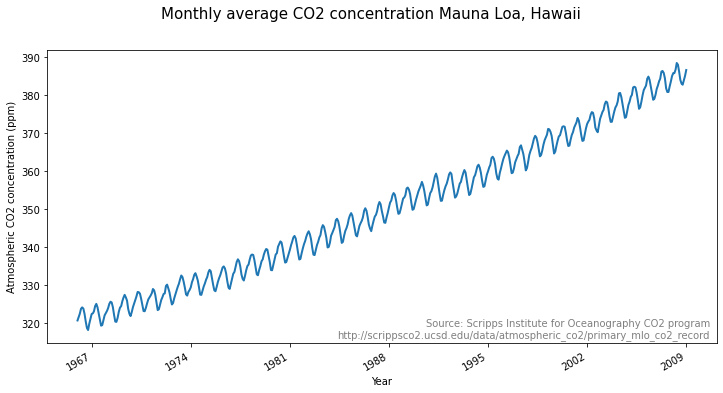

In [3]:
# CO2 readings from Mauna Loa observatory, monthly beginning January 1966
# Original source: http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record
co2_by_month = np.array(
    "320.62,321.60,322.39,323.70,324.08,323.75,322.38,320.36,318.64,318.10,319.78,321.03,322.33,322.50,323.04,324.42,325.00,324.09,322.54,320.92,319.25,319.39,320.73,321.96,322.57,323.15,323.89,325.02,325.57,325.36,324.14,322.11,320.33,320.25,321.32,322.89,324.00,324.42,325.63,326.66,327.38,326.71,325.88,323.66,322.38,321.78,322.85,324.12,325.06,325.98,326.93,328.14,328.08,327.67,326.34,324.69,323.10,323.06,324.01,325.13,326.17,326.68,327.17,327.79,328.92,328.57,327.36,325.43,323.36,323.56,324.80,326.01,326.77,327.63,327.75,329.73,330.07,329.09,328.04,326.32,324.84,325.20,326.50,327.55,328.55,329.56,330.30,331.50,332.48,332.07,330.87,329.31,327.51,327.18,328.16,328.64,329.35,330.71,331.48,332.65,333.09,332.25,331.18,329.39,327.43,327.37,328.46,329.57,330.40,331.40,332.04,333.31,333.97,333.60,331.90,330.06,328.56,328.34,329.49,330.76,331.75,332.56,333.50,334.58,334.88,334.33,333.05,330.94,329.30,328.94,330.31,331.68,332.93,333.42,334.70,336.07,336.75,336.27,334.92,332.75,331.59,331.16,332.40,333.85,334.97,335.38,336.64,337.76,338.01,337.89,336.54,334.68,332.76,332.55,333.92,334.95,336.23,336.76,337.96,338.88,339.47,339.29,337.73,336.09,333.92,333.86,335.29,336.73,338.01,338.36,340.07,340.77,341.47,341.17,339.56,337.60,335.88,336.02,337.10,338.21,339.24,340.48,341.38,342.51,342.91,342.25,340.49,338.43,336.69,336.86,338.36,339.61,340.75,341.61,342.70,343.57,344.14,343.35,342.06,339.81,337.98,337.86,339.26,340.49,341.38,342.52,343.10,344.94,345.76,345.32,343.98,342.38,339.87,339.99,341.15,342.99,343.70,344.50,345.28,347.06,347.43,346.80,345.39,343.28,341.07,341.35,342.98,344.22,344.97,345.99,347.42,348.35,348.93,348.25,346.56,344.67,343.09,342.80,344.24,345.56,346.30,346.95,347.85,349.55,350.21,349.55,347.94,345.90,344.85,344.17,345.66,346.90,348.02,348.48,349.42,350.99,351.85,351.26,349.51,348.10,346.45,346.36,347.81,348.96,350.43,351.73,352.22,353.59,354.22,353.79,352.38,350.43,348.73,348.88,350.07,351.34,352.76,353.07,353.68,355.42,355.67,355.12,353.90,351.67,349.80,349.99,351.30,352.52,353.66,354.70,355.38,356.20,357.16,356.23,354.81,352.91,350.96,351.18,352.83,354.21,354.72,355.75,357.16,358.60,359.34,358.24,356.17,354.02,352.15,352.21,353.75,354.99,355.99,356.72,357.81,359.15,359.66,359.25,357.02,355.00,353.01,353.31,354.16,355.40,356.70,357.17,358.38,359.46,360.28,359.60,357.57,355.52,353.69,353.99,355.34,356.80,358.37,358.91,359.97,361.26,361.69,360.94,359.55,357.48,355.84,356.00,357.58,359.04,359.97,361.00,361.64,363.45,363.80,363.26,361.89,359.45,358.05,357.75,359.56,360.70,362.05,363.24,364.02,364.71,365.41,364.97,363.65,361.48,359.45,359.61,360.76,362.33,363.18,363.99,364.56,366.36,366.80,365.63,364.47,362.50,360.19,360.78,362.43,364.28,365.33,366.15,367.31,368.61,369.30,368.88,367.64,365.78,363.90,364.23,365.46,366.97,368.15,368.87,369.59,371.14,371.00,370.35,369.27,366.93,364.64,365.13,366.68,368.00,369.14,369.46,370.51,371.66,371.83,371.69,370.12,368.12,366.62,366.73,368.29,369.53,370.28,371.50,372.12,372.86,374.02,373.31,371.62,369.55,367.96,368.09,369.68,371.24,372.44,373.08,373.52,374.85,375.55,375.40,374.02,371.48,370.70,370.25,372.08,373.78,374.68,375.62,376.11,377.65,378.35,378.13,376.61,374.48,372.98,373.00,374.35,375.69,376.79,377.36,378.39,380.50,380.62,379.55,377.76,375.83,374.05,374.22,375.84,377.44,378.34,379.61,380.08,382.05,382.24,382.08,380.67,378.67,376.42,376.80,378.31,379.96,381.37,382.02,382.56,384.37,384.92,384.03,382.28,380.48,378.81,379.06,380.14,381.66,382.58,383.71,384.34,386.23,386.41,385.87,384.45,381.84,380.86,380.86,382.36,383.61,385.07,385.84,385.83,386.77,388.51,388.05,386.25,384.08,383.09,382.78,384.01,385.11,386.65,387.12,388.52,389.57,390.16,389.62,388.07,386.08,384.65,384.33,386.05,387.49,388.55,390.07,391.01,392.38,393.22,392.24,390.33,388.52,386.84,387.16,388.67,389.81,391.30,391.92,392.45,393.37,394.28,393.69,392.59,390.21,389.00,388.93,390.24,391.80,393.07,393.35,394.36,396.43,396.87,395.88,394.52,392.54,391.13,391.01,392.95,394.34,395.61,396.85,397.26,398.35,399.98,398.87,397.37,395.41,393.39,393.70,395.19,396.82,397.92,398.10,399.47,401.33,401.88,401.31,399.07,397.21,395.40,395.65,397.23,398.79,399.85,400.31,401.51,403.45,404.10,402.88,401.61,399.00,397.50,398.28,400.24,401.89,402.65,404.16,404.85,407.57,407.66,407.00,404.50,402.24,401.01,401.50,403.64,404.55,406.07,406.64,407.06,408.95,409.91,409.12,407.20,405.24,403.27,403.64,405.17,406.75,408.05,408.34,409.25,410.30,411.30,410.88,408.90,407.10,405.59,405.99,408.12,409.23,410.92".split(",")
).astype(np.float32)
co2_by_month = jnp.array(co2_by_month[:, None])  

num_forecast_steps = 12 * 10  # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]

# Plot the original data
co2_dates = np.arange("1966-01", "2019-02", dtype="datetime64[M]")
co2_loc = mdates.YearLocator(7)
co2_fmt = mdates.DateFormatter("%Y")
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(co2_dates[:-num_forecast_steps], co2_by_month_training_data, lw=2, label='training data', markersize=1)
ax.xaxis.set_major_locator(co2_loc)
ax.xaxis.set_major_formatter(co2_fmt)
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")

fig.suptitle("Monthly average CO2 concentration Mauna Loa, Hawaii", fontsize=15)
ax.text(
    0.99,
    0.02,
    "Source: Scripps Institute for Oceanography CO2 program\nhttp://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record",
    transform=ax.transAxes,
    horizontalalignment='right',
    alpha=0.5
)
fig.autofmt_xdate()

In [4]:
trend = sts.LocalLinearTrend(observed_timeseries=co2_by_month_training_data)
seasonal = sts.Seasonal(num_seasons=12, observed_timeseries=co2_by_month_training_data)
model = sts.StructuralTimeSeries([trend, seasonal], observed_timeseries=co2_by_month_training_data)

In [5]:
batch_observed_time_series = jnp.array([co2_by_month_training_data])
key = jr.PRNGKey(0)
sample_size = 500

In [6]:
param_samps = model.fit_hmc(key, sample_size, batch_observed_time_series, batch_inputs=None)

/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


  0%|          | 0/500 [00:00<?, ?it/s]